In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
import random
import warnings
warnings.filterwarnings('ignore')

RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
CIFAR10_CLASSES = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
                   'dog', 'frog', 'horse', 'ship', 'truck']

Using device: cuda


In [3]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=True,
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(
            out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True
        )
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_channels,
                    self.expansion * out_channels,
                    kernel_size=1,
                    stride=stride,
                    bias=True,
                ),
                nn.BatchNorm2d(self.expansion * out_channels),
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(64, 2, stride=1)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)
        self.linear = nn.Linear(512 * BasicBlock.expansion, num_classes)

    def _make_layer(self, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(BasicBlock(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * BasicBlock.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


baseline_model = ResNet18(num_classes=10).to(device)
print(
    f"Baseline model created with {sum(p.numel() for p in baseline_model.parameters())} parameters"
)

Baseline model created with 11178698 parameters


In [4]:
def get_cifar10_loaders(batch_size=128):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    train_dataset = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=transform)
    
    test_dataset = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=transform)

    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = get_cifar10_loaders()
print(f"Training samples: {len(train_loader.dataset)}")
print(f"Validation samples: {len(val_loader.dataset)}")
print(f"Test samples: {len(test_loader.dataset)}")

Training samples: 40000
Validation samples: 10000
Test samples: 10000


In [5]:
def train_epoch(model, train_loader, criterion, optimizer, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
        
        if batch_idx % 100 == 0:
            print(f'Epoch {epoch}, Batch {batch_idx}, Loss: {loss.item():.4f}')
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

def evaluate(model, data_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_predictions = []
    all_targets = []
    all_confidences = []
    
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            
            running_loss += loss.item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
            
            probs = F.softmax(output, dim=1)
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
            all_confidences.extend(probs.max(dim=1)[0].cpu().numpy())
    
    epoch_loss = running_loss / len(data_loader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc, all_predictions, all_targets, all_confidences

In [6]:
def train_model(model, train_loader, val_loader, num_epochs=30, learning_rate=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    
    best_val_acc = 0
    best_model_state = None
    
    print("Starting training...")
    
    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, epoch)
        
        val_loss, val_acc, _, _, _ = evaluate(model, val_loader, criterion)
        
        scheduler.step()
        
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        print('-' * 50)
    
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f'Best validation accuracy: {best_val_acc:.2f}%')
    
    return model, train_losses, train_accs, val_losses, val_accs

baseline_model, train_losses, train_accs, val_losses, val_accs = train_model(
    baseline_model, train_loader, val_loader, num_epochs=30
)

Starting training...
Epoch 0, Batch 0, Loss: 2.4196
Epoch 0, Batch 100, Loss: 1.3712
Epoch 0, Batch 200, Loss: 1.3247
Epoch 0, Batch 300, Loss: 1.0865
Epoch 1/30:
Train Loss: 1.3918, Train Acc: 48.80%
Val Loss: 1.5606, Val Acc: 46.75%
--------------------------------------------------
Epoch 1, Batch 0, Loss: 1.0334
Epoch 1, Batch 100, Loss: 0.9604
Epoch 1, Batch 200, Loss: 0.8903
Epoch 1, Batch 300, Loss: 0.7072
Epoch 2/30:
Train Loss: 0.9164, Train Acc: 67.58%
Val Loss: 0.9058, Val Acc: 68.13%
--------------------------------------------------
Epoch 2, Batch 0, Loss: 0.7616
Epoch 2, Batch 100, Loss: 0.6773
Epoch 2, Batch 200, Loss: 0.7287
Epoch 2, Batch 300, Loss: 0.5354
Epoch 3/30:
Train Loss: 0.7081, Train Acc: 75.13%
Val Loss: 0.7568, Val Acc: 73.13%
--------------------------------------------------
Epoch 3, Batch 0, Loss: 0.6796
Epoch 3, Batch 100, Loss: 0.5888
Epoch 3, Batch 200, Loss: 0.4085
Epoch 3, Batch 300, Loss: 0.6338
Epoch 4/30:
Train Loss: 0.5753, Train Acc: 79.94%
Val 

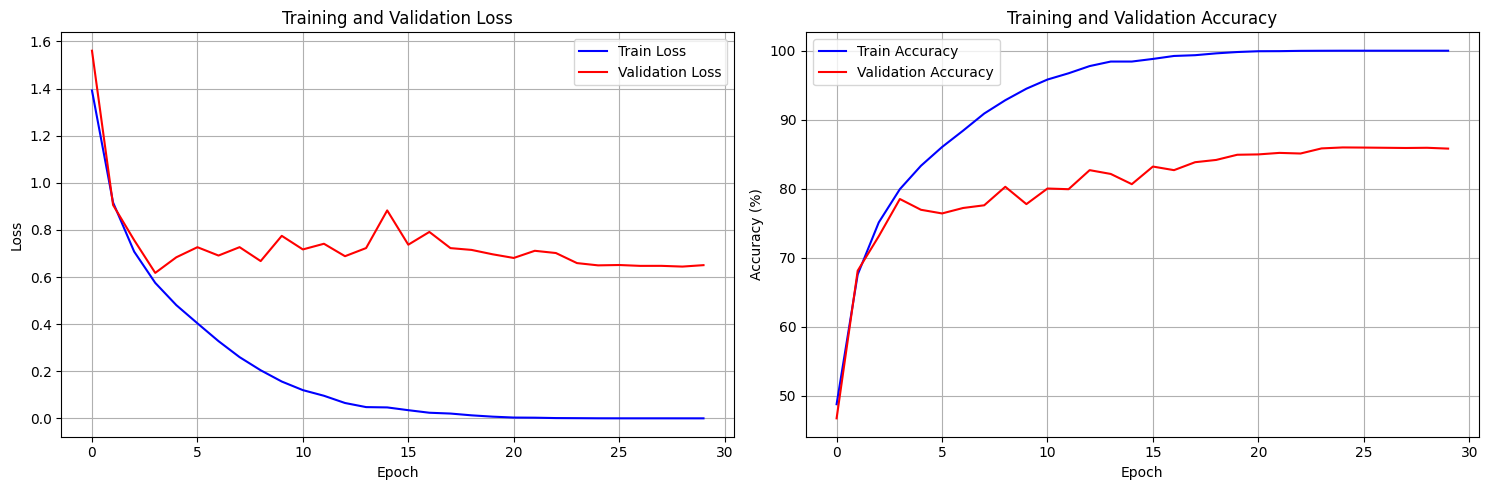

In [7]:
def plot_training_curves(train_losses, train_accs, val_losses, val_accs):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    ax1.plot(train_losses, label='Train Loss', color='blue')
    ax1.plot(val_losses, label='Validation Loss', color='red')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    ax2.plot(train_accs, label='Train Accuracy', color='blue')
    ax2.plot(val_accs, label='Validation Accuracy', color='red')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_training_curves(train_losses, train_accs, val_losses, val_accs)

In [8]:
def test_and_find_failures(model, test_loader):
    criterion = nn.CrossEntropyLoss()
    test_loss, test_acc, predictions, targets, confidences = evaluate(model, test_loader, criterion)
    
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%')
    
    failure_cases = []
    for i, (pred, target, conf) in enumerate(zip(predictions, targets, confidences)):
        if pred != target and conf > 0.8:
            failure_cases.append({
                'index': i,
                'predicted': pred,
                'target': target,
                'confidence': conf,
                'predicted_class': CIFAR10_CLASSES[pred],
                'target_class': CIFAR10_CLASSES[target]
            })
    
    failure_cases.sort(key=lambda x: x['confidence'], reverse=True)
    
    print(f"Found {len(failure_cases)} high-confidence failure cases")
    
    return test_acc, failure_cases

test_acc, failure_cases = test_and_find_failures(baseline_model, test_loader)

print("\nTop 3 Failure Cases:")
for i, case in enumerate(failure_cases[:3]):
    print(f"Case {i+1}:")
    print(f"  Target: {case['target_class']} (class {case['target']})")
    print(f"  Predicted: {case['predicted_class']} (class {case['predicted']})")
    print(f"  Confidence: {case['confidence']:.4f}")
    print()

Test Loss: 0.6675, Test Accuracy: 85.67%
Found 886 high-confidence failure cases

Top 3 Failure Cases:
Case 1:
  Target: cat (class 3)
  Predicted: dog (class 5)
  Confidence: 1.0000

Case 2:
  Target: ship (class 8)
  Predicted: airplane (class 0)
  Confidence: 1.0000

Case 3:
  Target: dog (class 5)
  Predicted: horse (class 7)
  Confidence: 1.0000




Analyzing Failure Case 1:


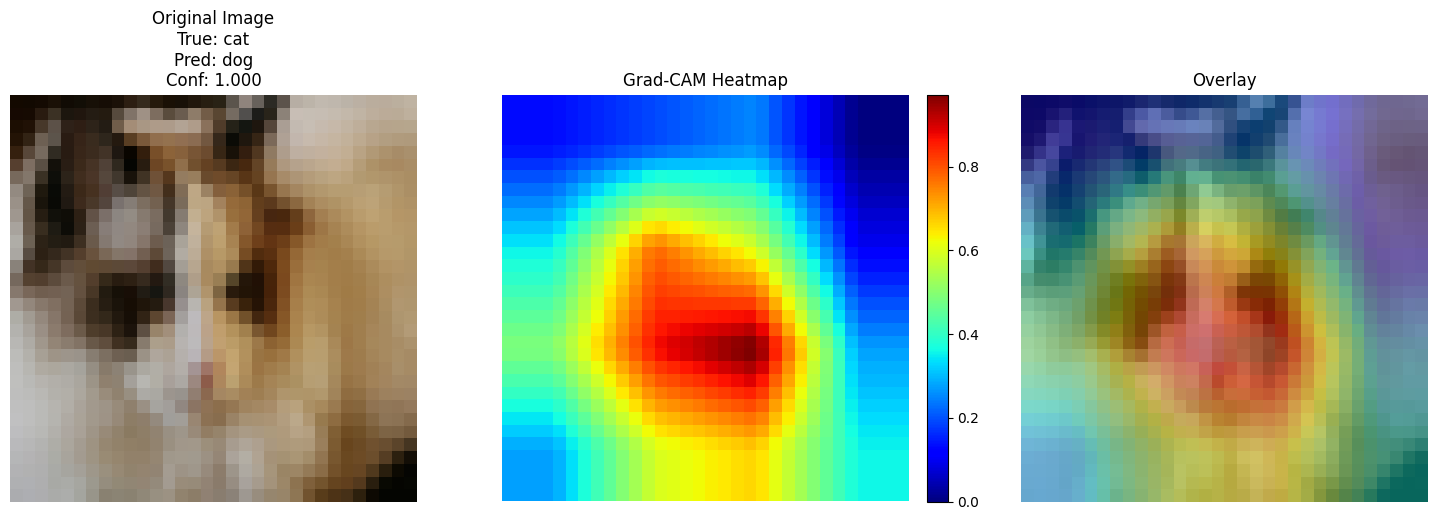


Analyzing Failure Case 2:


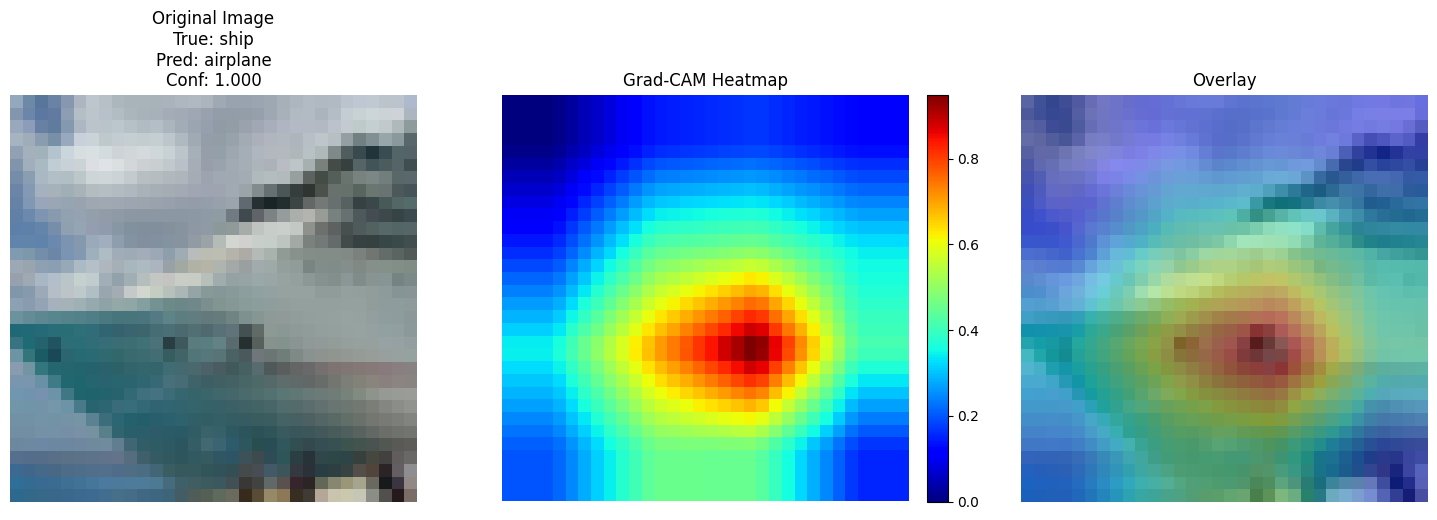


Analyzing Failure Case 3:


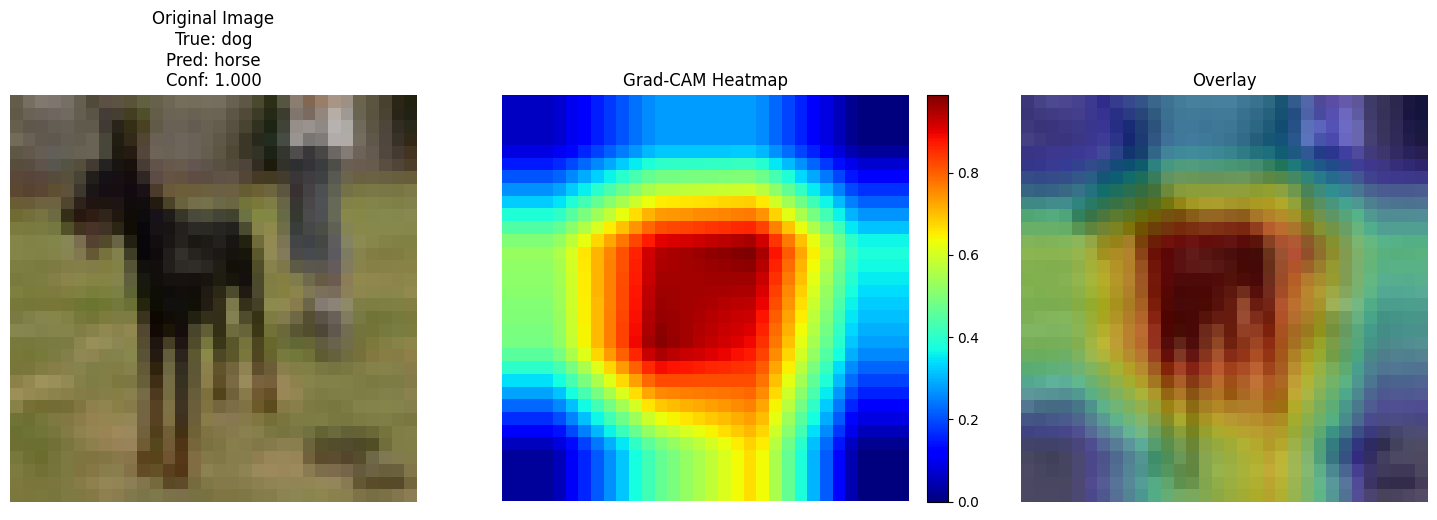

In [9]:
import cv2

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        self.target_layer.register_forward_hook(self.save_activation)
        self.target_layer.register_backward_hook(self.save_gradient)
    
    def save_activation(self, module, input, output):
        self.activations = output
    
    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]
    
    def __call__(self, x, class_idx=None):
        output = self.model(x)
        
        if class_idx is None:
            class_idx = output.argmax(dim=1).item()
        
        self.model.zero_grad()
        class_loss = output[0, class_idx]
        class_loss.backward()
        
        gradients = self.gradients[0]
        activations = self.activations[0]
        weights = gradients.mean(dim=(1, 2))
        
        cam = torch.zeros(activations.shape[1:], dtype=torch.float32, device=activations.device)
        for i, w in enumerate(weights):
            cam += w * activations[i]
        
        cam = torch.relu(cam)
        cam = cam - cam.min()
        cam = cam / cam.max()
        
        return cam.detach().cpu().numpy()

def visualize_failure_case_with_gradcam(model, test_loader, failure_case_idx):
    case = failure_cases[failure_case_idx]
    dataset = test_loader.dataset
    
    image, target = dataset[case['index']]
    image_tensor = image.unsqueeze(0).to(device)
    
    target_layer = model.layer4[-1]
    grad_cam = GradCAM(model, target_layer)
    
    heatmap = grad_cam(image_tensor, case['predicted'])
    
    # Resize heatmap to match image size
    heatmap = cv2.resize(heatmap, (image.shape[2], image.shape[1]))
    
    mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
    std = torch.tensor([0.2023, 0.1994, 0.2010]).view(3, 1, 1)
    denormalized_img = image * std + mean
    denormalized_img = torch.clamp(denormalized_img, 0, 1)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    
    ax1.imshow(denormalized_img.permute(1, 2, 0))
    ax1.set_title(f'Original Image\nTrue: {case["target_class"]}\nPred: {case["predicted_class"]}\nConf: {case["confidence"]:.3f}')
    ax1.axis('off')
    
    im = ax2.imshow(heatmap, cmap='jet')
    ax2.set_title('Grad-CAM Heatmap')
    ax2.axis('off')
    plt.colorbar(im, ax=ax2, fraction=0.046, pad=0.04)
    
    ax3.imshow(denormalized_img.permute(1, 2, 0))
    ax3.imshow(heatmap, cmap='jet', alpha=0.4)
    ax3.set_title('Overlay')
    ax3.axis('off')
    
    plt.tight_layout()
    plt.savefig(f'failure_case_{failure_case_idx+1}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return case, heatmap

for i in range(min(3, len(failure_cases))):
    print(f"\nAnalyzing Failure Case {i+1}:")
    case, heatmap = visualize_failure_case_with_gradcam(baseline_model, test_loader, i)

In [10]:
def get_improved_loaders(batch_size=128):
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        transforms.RandomErasing(p=0.1, scale=(0.02, 0.1)),
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    train_dataset = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=transform_train)
    
    test_dataset = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=transform_test)

    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    return train_loader, val_loader, test_loader

print("Training improved model with enhanced data augmentation...")
improved_model = ResNet18(num_classes=10).to(device)

improved_train_loader, improved_val_loader, improved_test_loader = get_improved_loaders()

improved_model, imp_train_losses, imp_train_accs, imp_val_losses, imp_val_accs = train_model(
    improved_model, improved_train_loader, improved_val_loader, num_epochs=30
)

Training improved model with enhanced data augmentation...
Starting training...
Epoch 0, Batch 0, Loss: 2.4277
Epoch 0, Batch 100, Loss: 1.7487
Epoch 0, Batch 200, Loss: 1.4217
Epoch 0, Batch 300, Loss: 1.5793
Epoch 1/30:
Train Loss: 1.6532, Train Acc: 38.77%
Val Loss: 1.5255, Val Acc: 45.97%
--------------------------------------------------
Epoch 1, Batch 0, Loss: 1.3564
Epoch 1, Batch 100, Loss: 1.0647
Epoch 1, Batch 200, Loss: 1.2339
Epoch 1, Batch 300, Loss: 1.2921
Epoch 2/30:
Train Loss: 1.2285, Train Acc: 55.81%
Val Loss: 1.3533, Val Acc: 53.42%
--------------------------------------------------
Epoch 2, Batch 0, Loss: 1.1213
Epoch 2, Batch 100, Loss: 0.8047
Epoch 2, Batch 200, Loss: 1.0207
Epoch 2, Batch 300, Loss: 0.9611
Epoch 3/30:
Train Loss: 1.0366, Train Acc: 63.31%
Val Loss: 1.1174, Val Acc: 62.06%
--------------------------------------------------
Epoch 3, Batch 0, Loss: 0.8555
Epoch 3, Batch 100, Loss: 0.8851
Epoch 3, Batch 200, Loss: 0.9471
Epoch 3, Batch 300, Loss: 0.

Model Comparison:
Baseline Model - Test Accuracy: 85.67%, Test Loss: 0.6675
Improved Model - Test Accuracy: 91.75%, Test Loss: 0.2888
Accuracy Improvement: 6.08%


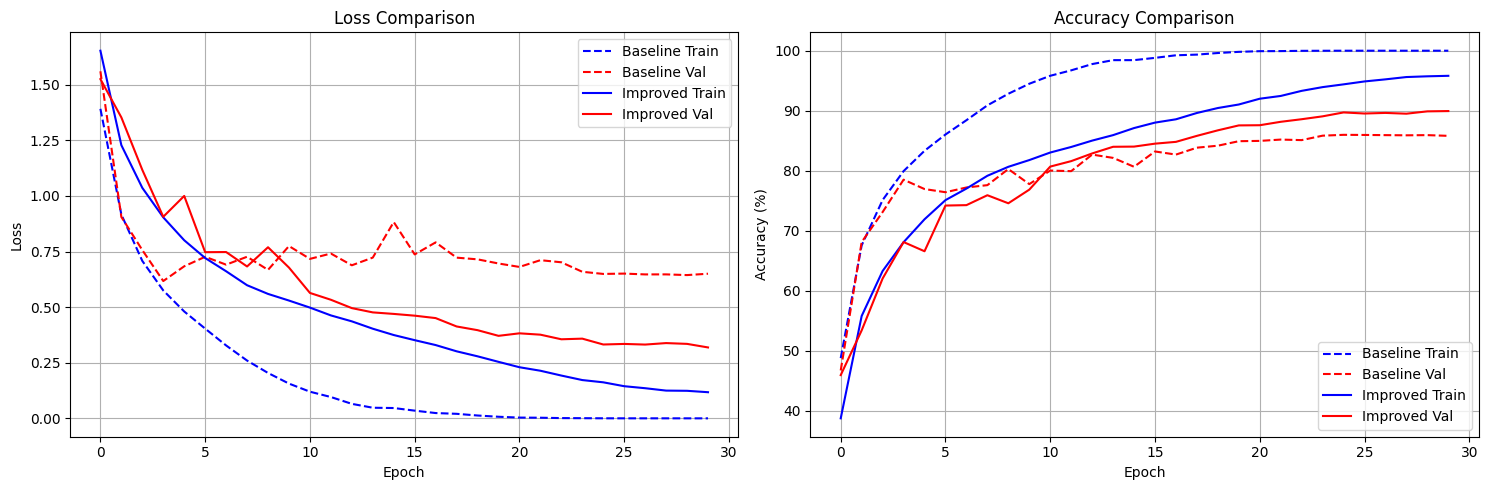

In [11]:
def compare_models(baseline_model, improved_model, baseline_test_loader, improved_test_loader):
    criterion = nn.CrossEntropyLoss()
    
    baseline_loss, baseline_acc, _, _, _ = evaluate(baseline_model, baseline_test_loader, criterion)
    
    improved_loss, improved_acc, _, _, _ = evaluate(improved_model, improved_test_loader, criterion)
    
    print("Model Comparison:")
    print(f"Baseline Model - Test Accuracy: {baseline_acc:.2f}%, Test Loss: {baseline_loss:.4f}")
    print(f"Improved Model - Test Accuracy: {improved_acc:.2f}%, Test Loss: {improved_loss:.4f}")
    print(f"Accuracy Improvement: {improved_acc - baseline_acc:.2f}%")
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    ax1.plot(train_losses, label='Baseline Train', color='blue', linestyle='--')
    ax1.plot(val_losses, label='Baseline Val', color='red', linestyle='--')
    ax1.plot(imp_train_losses, label='Improved Train', color='blue')
    ax1.plot(imp_val_losses, label='Improved Val', color='red')
    ax1.set_title('Loss Comparison')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    ax2.plot(train_accs, label='Baseline Train', color='blue', linestyle='--')
    ax2.plot(val_accs, label='Baseline Val', color='red', linestyle='--')
    ax2.plot(imp_train_accs, label='Improved Train', color='blue')
    ax2.plot(imp_val_accs, label='Improved Val', color='red')
    ax2.set_title('Accuracy Comparison')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return baseline_acc, improved_acc

baseline_acc, improved_acc = compare_models(
    baseline_model, improved_model, test_loader, improved_test_loader
)

In [12]:
def analyze_improved_failures(improved_model, improved_test_loader):
    criterion = nn.CrossEntropyLoss()
    _, _, predictions, targets, confidences = evaluate(improved_model, improved_test_loader, criterion)
    
    improved_failures = []
    for i, (pred, target, conf) in enumerate(zip(predictions, targets, confidences)):
        if pred != target and conf > 0.8:
            improved_failures.append({
                'index': i,
                'predicted': pred,
                'target': target,
                'confidence': conf,
                'predicted_class': CIFAR10_CLASSES[pred],
                'target_class': CIFAR10_CLASSES[target]
            })
    
    improved_failures.sort(key=lambda x: x['confidence'], reverse=True)
    
    print(f"Improved model found {len(improved_failures)} high-confidence failure cases")
    print(f"Reduction in failures: {len(failure_cases) - len(improved_failures)} cases")
    
    print("\nComparison of Top 3 Failure Cases:")
    print("Baseline vs Improved Model")
    print("-" * 60)
    
    for i in range(min(3, len(failure_cases), len(improved_failures))):
        baseline_case = failure_cases[i]
        improved_case = improved_failures[i] if i < len(improved_failures) else None
        
        print(f"Case {i+1}:")
        print(f"  Baseline: {baseline_case['target_class']} -> {baseline_case['predicted_class']} (conf: {baseline_case['confidence']:.3f})")
        if improved_case:
            print(f"  Improved: {improved_case['target_class']} -> {improved_case['predicted_class']} (conf: {improved_case['confidence']:.3f})")
        else:
            print(f"  Improved: No high-confidence failure")
        print()
    
    return improved_failures

improved_failures = analyze_improved_failures(improved_model, improved_test_loader)


Improved model found 418 high-confidence failure cases
Reduction in failures: 468 cases

Comparison of Top 3 Failure Cases:
Baseline vs Improved Model
------------------------------------------------------------
Case 1:
  Baseline: cat -> dog (conf: 1.000)
  Improved: cat -> frog (conf: 1.000)

Case 2:
  Baseline: ship -> airplane (conf: 1.000)
  Improved: automobile -> truck (conf: 1.000)

Case 3:
  Baseline: dog -> horse (conf: 1.000)
  Improved: cat -> bird (conf: 1.000)



Generating confusion matrix for baseline model...


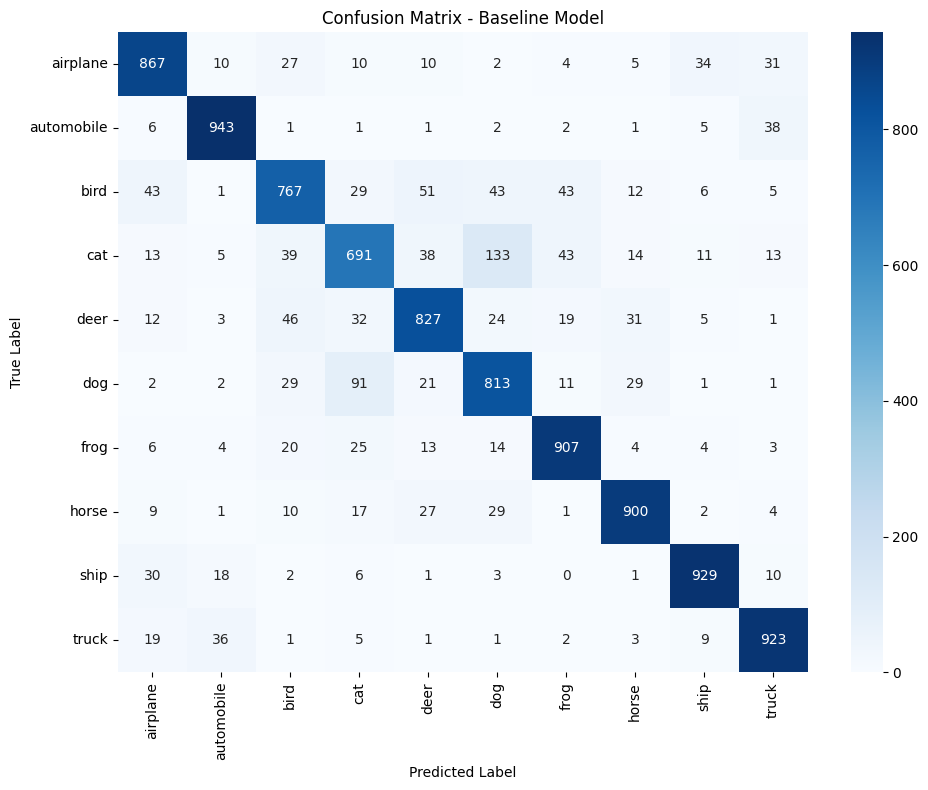


Generating confusion matrix for improved model...


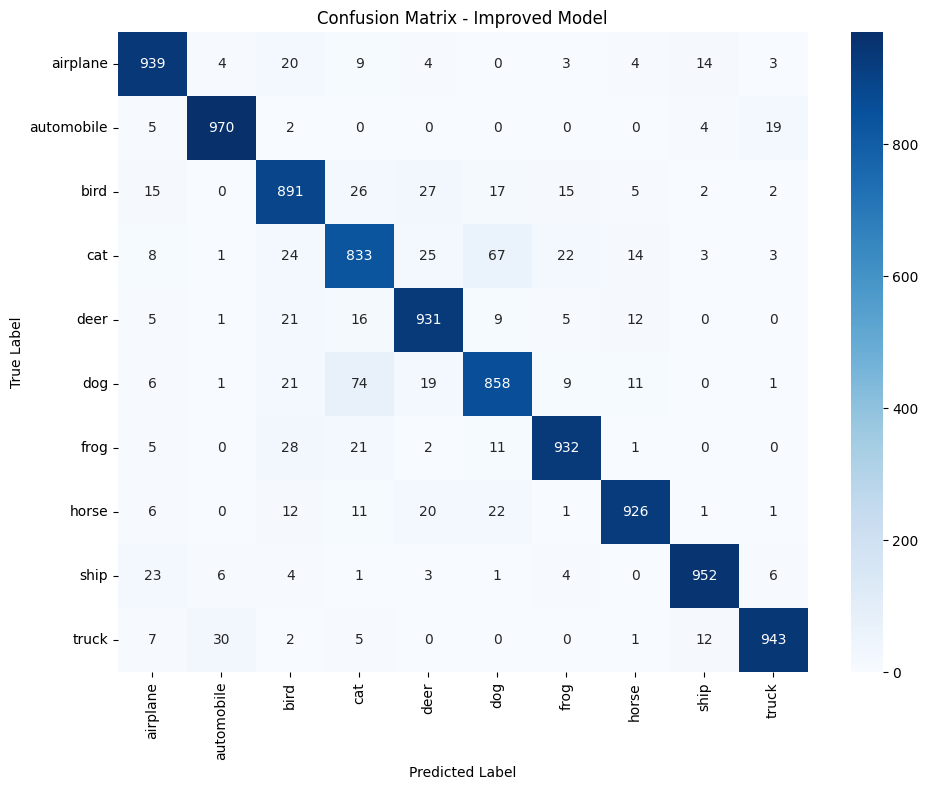

In [13]:
def plot_confusion_matrix(model, test_loader, model_name="Model"):
    criterion = nn.CrossEntropyLoss()
    _, _, predictions, targets, _ = evaluate(model, test_loader, criterion)
    
    cm = confusion_matrix(targets, predictions)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=CIFAR10_CLASSES, yticklabels=CIFAR10_CLASSES)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.savefig(f'confusion_matrix_{model_name.lower().replace(" ", "_")}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return cm

# Plot confusion matrices for both models
print("Generating confusion matrix for baseline model...")
baseline_cm = plot_confusion_matrix(baseline_model, test_loader, "Baseline Model")

print("\nGenerating confusion matrix for improved model...")
improved_cm = plot_confusion_matrix(improved_model, improved_test_loader, "Improved Model")